In [ ]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation


### Практический пример с соревнования X5 

http://retailhero.ai/#rec141268104

Импортируем нужные библиотеки и предобработаем данные:

In [6]:
# !pip install scikit-uplift==0.2.0

Посмотрим на топ-признаки

# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [12]:
# Чтение данных
df = pd.read_csv('data.csv')#, index_col='client_id')



In [14]:
df.rename(columns ={'conversion':'target', 'offer':'treatment'}, inplace=True)

In [15]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [16]:
df.loc[df['treatment'] == 'Buy One Get One', 'treatment']=1
df.loc[df['treatment'] == 'Discount', 'treatment']=1
df.loc[df['treatment'] == 'No Offer', 'treatment']=0

In [17]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [18]:
models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%':[],
    'uplift@10%':[]
}

In [19]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [20]:
treat_train = X_train['treatment']
X_train= X_train.drop(columns=['treatment'], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 1098 to 2732
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        48000 non-null  int64  
 1   history        48000 non-null  float64
 2   used_discount  48000 non-null  int64  
 3   used_bogo      48000 non-null  int64  
 4   zip_code       48000 non-null  object 
 5   is_referral    48000 non-null  int64  
 6   channel        48000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ MB


In [21]:
X_train['zip_code'].value_counts()

Surburban    21599
Urban        19218
Rural         7183
Name: zip_code, dtype: int64

In [22]:
X_train['channel'].value_counts()

Web             21122
Phone           21045
Multichannel     5833
Name: channel, dtype: int64

In [23]:
cat_features = ['zip_code','channel']

In [24]:
treat_train

1098     1
13764    1
45116    1
15363    0
44498    0
        ..
45891    0
52416    1
42613    1
43567    1
2732     1
Name: treatment, Length: 48000, dtype: object

In [25]:
y_train

1098     0
13764    0
45116    0
15363    0
44498    0
        ..
45891    0
52416    1
42613    1
43567    0
2732     0
Name: target, Length: 48000, dtype: int64

uplift@30%: 0.0573
uplift@20%: 0.0612
uplift@10%: 0.0565


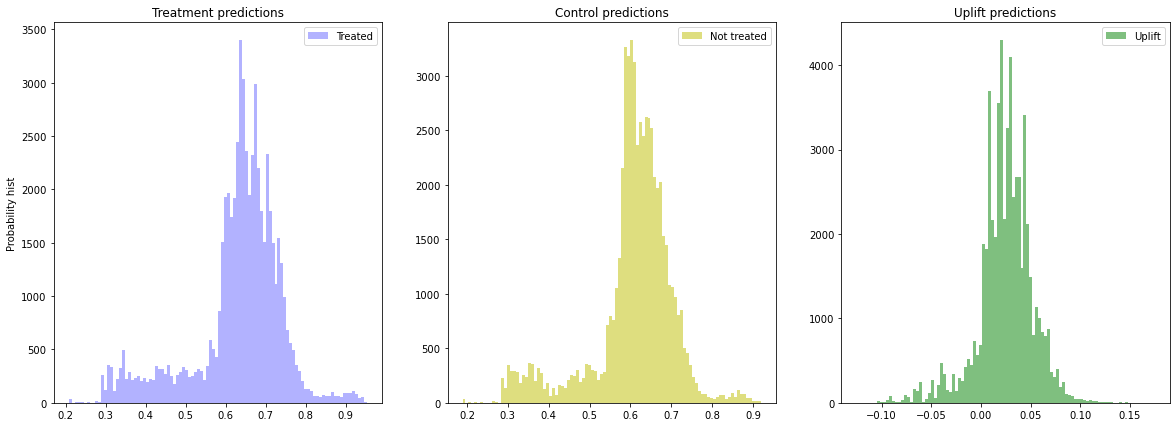

In [26]:
sm1 = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm1 = sm1.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm1 = sm.predict(X_val)

sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm1, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score_30:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_30)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm1, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['uplift@20%'].append(sm_score_20)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm1, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [27]:
treat_test = X_test['treatment']
X_test= X_test.drop(columns=['treatment'], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 11277 to 26707
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        16000 non-null  int64  
 1   history        16000 non-null  float64
 2   used_discount  16000 non-null  int64  
 3   used_bogo      16000 non-null  int64  
 4   zip_code       16000 non-null  object 
 5   is_referral    16000 non-null  int64  
 6   channel        16000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 1000.0+ KB


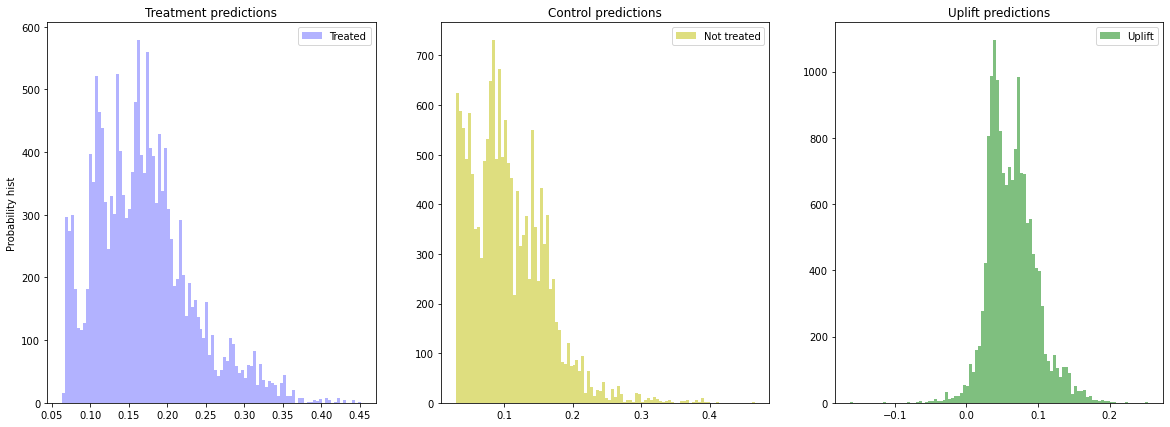

In [28]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_30)

tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.2)

models_results['uplift@20%'].append(tm_score_20)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.1)

models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [37]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_30)

ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(ct_score_20)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.1)

models_results['uplift@10%'].append(ct_score_10)

<ipython-input-37-aeecd10b78ad>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [30]:
models_results

{'approach': ['SoloModel', 'TwoModels', 'ClassTransformation'],
 'uplift@30%': [0.05726192634218552, 0.06754422137392589, 0.062555571264747],
 'uplift@20%': [0.06115649264328227, 0.07370455605989903, 0.06109258120165728],
 'uplift@10%': [0.05654627028006887, 0.06673351158645277, 0.06470694338341396]}

In [31]:
print(pd.DataFrame(models_results))


              approach  uplift@30%  uplift@20%  uplift@10%
0            SoloModel    0.057262    0.061156    0.056546
1            TwoModels    0.067544    0.073705    0.066734
2  ClassTransformation    0.062556    0.061093    0.064707


Вариант с деревом решений

In [38]:
!git clone https://github.com/ub8er/causalml.git
%cd causalml
!pip install -r requirements.txt
!python setup.py build_ext --inplace
!python setup.py install

fatal: destination path 'causalml' already exists and is not an empty directory.
/Users/maria/Documents/GeekBrains/ML  в бизнесе/урок 4/lection4_materials/causalml/causalml
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
python: can't open file 'setup.py': [Errno 2] No such file or directory
python: can't open file 'setup.py': [Errno 2] No such file or directory


In [34]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),\
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In [35]:
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
1098,8,63.58,1,0,1,0,1,0,0,1,0
13764,3,395.35,1,0,1,0,1,0,0,0,1
45116,4,1307.99,1,1,1,1,0,0,0,1,0
15363,10,159.01,0,1,1,0,1,0,0,0,1
44498,1,276.00,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
45891,9,34.26,1,0,0,0,0,1,0,1,0
52416,5,264.71,1,1,0,0,0,1,1,0,0
42613,12,419.44,0,1,1,0,0,1,1,0,0
43567,1,331.56,0,1,0,0,0,1,1,0,0


#### Поставить causalml так и не получилось

In [42]:
%%time
from IPython.display import Image
from  causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
#from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

#graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
#Image(graph.create_png())
tree.plot_tree(uplift_model.fitted_uplift_tree)

ModuleNotFoundError: No module named 'shap'

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html